# Aim

In trying to build a simulation of atmospheric tip-tilts to correct using a Kalman-LQG controller, I've run into problems separating out tip and tilt from a phase screen, and in creating a specified tip or tilt in the focal plane intensity based on the phase at the pupil plane. This notebook demonstrates these problems.

In [43]:
# imports and setup

# I have hcipy as a submodule, so this import may vary
import sys
sys.path.append("..")
from hcipy.hcipy import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage, signal, optimize

pupil_size = 16
focal_samples = 8 # samples per lambda over D
focal_width = 8 # half the number of lambda over Ds
wavelength = 500e-9 # m
f_sampling = 1000
T = 1
times = np.arange(0, T, 1/f_sampling)
pupil_grid = make_pupil_grid(pupil_size, 1)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, q=focal_samples, num_airy=focal_width)
prop = FraunhoferPropagator(pupil_grid, focal_grid, wavelength=wavelength)
aperture = circular_aperture(1)(pupil_grid)
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
#layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity, use_interpolation=True)

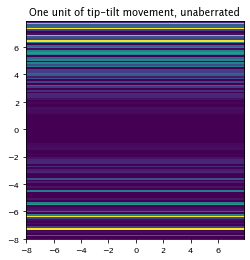

'imshow_field(tt_img_ab)\nplt.title("One unit of tip-tilt movement, aberrated")\nplt.show()'

In [44]:
# first, I want to generate one unit of movement in both x and y

tt = [zernike(*ansi_to_zernike(i), 1)(pupil_grid) for i in (1, 2)] # tip-tilt phase basis
tt_weights = (10, 0) # number of lambda-over-Ds I want to move the CM
tt_wf = Wavefront(aperture * np.exp(1j * 2 * np.pi * sum([w * z for w, z in zip(tt_weights, tt)])), wavelength)
tt_img = prop(tt_wf).intensity
#tt_img_ab = prop(Wavefront(tt_wf.electric_field * np.exp(1j * layer.phase_for(wavelength)), wavelength)).intensity
imshow_field(tt_img)
plt.title("One unit of tip-tilt movement, unaberrated")
plt.show()
'''imshow_field(tt_img_ab)
plt.title("One unit of tip-tilt movement, aberrated")
plt.show()'''

In [45]:
def center_of_mass(f):
    dims = np.array([np.max(f.grid.x) - np.min(f.grid.x), np.max(f.grid.y) - np.min(f.grid.y)])
    average = np.array([(f.grid.x * f).sum(), (f.grid.y * f).sum()]) / (f.sum())
    return average / dims

# expected: only values between -1 and +1

unaberrated_cm = center_of_mass(tt_img)
#aberrated_cm = center_of_mass(tt_img_ab)
print("Unaberrated CM", unaberrated_cm)
#print("Aberrated CM", aberrated_cm)

Unaberrated CM [-0.00393701  0.11045303]


In [ ]:
# I want to simulate only TT not being controlled. First I'll use a ModalAOLayer.
corrected_layer = ModalAdaptiveOpticsLayer(layer, controlled_modes=ModeBasis(tt), lag=0)

Next, we run atmosphere tip-tilt in a loop so that its time-series and PSD can be examined. First, let's figure out dimensions: the output plane is in pixels that I can translate to lambda-over-Ds by scaling by focal_samples. lambda/D is rad: 1 lambda over D is about 500e-9/10 = 5e-8 = 10.313 mas, so one px is 0.10313 mas.

Note that below I use a method that I wrote into ModalAdaptiveOpticsLayer.py to just get the correction for a mode basis, instead of the residual of the correction. This is equivalent (I think) to just having a ModeBasis with all modes that aren't tip and tilt.

In [ ]:
def correction_for(self, wavelength):
    return self.transformation_matrix.dot(self.corrected_coeffs[0] / wavelength)

def correct_until(self, t):
    self.layer.evolve_until(t)

    if len(self.corrected_coeffs) > 0:
        coeffs = self.transformation_matrix_inverse.dot(self.correction_for(1))
    else:
        coeffs = self.transformation_matrix_inverse.dot(self.layer.phase_for(1))
    if len(self.corrected_coeffs) > self.lag:
        self.corrected_coeffs.pop(0)
    self.corrected_coeffs.append(coeffs)
    
ModalAdaptiveOpticsLayer.correction_for = correction_for
ModalAdaptiveOpticsLayer.correct_until = correct_until

In [ ]:
conversion = (wavelength / D) * 206265000 / focal_samples

tt_cms = np.zeros((f_sampling * T, 2))
for n in range(f_sampling * T):
    corrected_layer.correct_until(times[n]) 
    wf = Wavefront(aperture * np.exp(1j * corrected_layer.phase_for(wavelength)), wavelength)
    total_intensity = prop(wf).intensity
    tt_cms[n] = center_of_mass(total_intensity)
    
tt_cms *= conversion # pixels to mas

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(tt_cms[:,0], tt_cms[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Atmospheric tip-tilts")

In [ ]:
# plotting the PSD of just one dimension, expecting an f^-2 power law
plt.figure(figsize=(10,10))
freqs, power = signal.periodogram(tt_cms[:,1], f_sampling)
power_law_to_fit = np.vectorize(lambda f, a, b, c: a/(f + b)**2 + c)
par0 = [1, 1, 0]
par, cov = optimize.curve_fit(power_law_to_fit, freqs, power, par0)
print(par)
plt.loglog(freqs, power, label='Actual')
plt.loglog(freqs, power_law_to_fit(freqs, *par0))
plt.ylim(1e-7)